In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
from pathlib import Path
from pynini import Weight

sys.path.append(str(Path.home() / 'Code/Python/wynini'))
from wynini import config as wconfig
from wynini import wfst
from wynini.wfst import *

/home/colin/Code/Python/wynini/wynini/wfst.py:1423: SyntaxWarning: invalid escape sequence '\o'
  """


In [2]:
help(wconfig)
wconfig.init({'sigma': ['a', 'b', 'c']})

Help on module wynini.config in wynini:

NAME
    wynini.config

FUNCTIONS
    init(config={})
        Set globals with dictionary or module

    make_symtable(sigma)

DATA
    bos = '⋊'
    eos = '⋉'
    epsilon = 'ϵ'
    sigma = ['a', 'b']
    special_syms = []
    syms = []
    symtable = None
    unk = '⊥'
    verbosity = 0
    λ = ''

FILE
    /home/colin/Code/Python/wynini/wynini/config.py




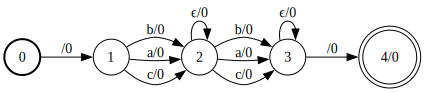

In [3]:
M = braid(2, arc_type='log')
one = Weight('log', 0.0)
M.assign_weights(lambda M, q, t: one)

#M = trellis(2)
#M = ngram(context='left', length=1)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [4]:
beta = shortestdistance(M, reverse=True)
beta = np.array([float(w) for w in beta])
print(np.exp(-beta))

[2.44335813e+11 2.44335813e+11 2.44335813e+11 6.99050665e+05
 1.00000000e+00]


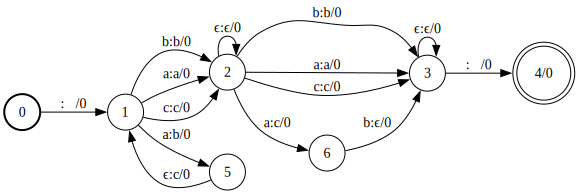

In [5]:
# Add paths.
M.add_path(src=1, ilabel='a', olabel='b c', weight=None, dest=1)
M.add_path(src=2, ilabel='a b', olabel='c', weight=None, dest=3)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [6]:
# Concatenation.
wfst1 = Wfst()
q0 = wfst1.add_state(initial=True)
q1 = wfst1.add_state(final=True)
wfst1.add_arc(q0, 'a', 'a', None, q1)
print(wfst1.print())

wfst2 = Wfst()
q0 = wfst2.add_state(initial=True)
q1 = wfst2.add_state(final=True)
wfst2.add_arc(q0, 'b', 'b', None, q1)
print(wfst2.print())

wfst12 = concat(wfst1, wfst2)
print(wfst12.print())

0	1	a	a
1

0	1	b	b
1

(0, 1)	(1, 1)	a	a
(1, 1)	(0, 2)	ϵ	ϵ
(0, 2)	(1, 2)	b	b
(1, 2)



In [7]:
# Optionality.
wfst = ques(wfst1)
print(wfst.print())

# Star.
wfst = star(wfst1)
print(wfst.print())

0	1	a	a
0	2	ϵ	ϵ
1
2

